In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import gget
import tabulate
from sklearn.neighbors import BallTree
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.stats import gmean
import networkx as nx
import sys

# locals
sys.path.append('../')
import utils as ut

sys.path.append("/home/cstansbu/.local/lib/python3.7/site-packages/pycircos/")
import pycircos

In [2]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath, engine="openpyxl")
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


,Pair.Name,Ligand.Mouse,Receptor.Mouse,Source,ManualAnnotation,Ligand.CC,Ligand.GO,Reference (PMID / KEGG),ligand,receptor
0,A2m-Lrp1,A2m,Lrp1,Ramilowski,Correct,Secreted,Other,"1702392,10652313, 12194978",A2M,LRP1
1,Adgre5-Cd55,Adgre5,Cd55,Baccin,Correct,Membrane,Other,23447688,ADGRE5,CD55
2,Adipoq-Adipor1,Adipoq,Adipor1,Ramilowski,Correct,Secreted,Other,12802337,ADIPOQ,ADIPOR1
3,Adipoq-Adipor2,Adipoq,Adipor2,Ramilowski,Correct,Secreted,Other,"12802337, 12802330",ADIPOQ,ADIPOR2
4,Adm-Calcrl&Ramp2,Adm,Calcrl&Ramp2,Baccin,Correct,Secreted,Other,10342881,ADM,CALCRL&RAMP2


In [3]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'macrophage' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
df.head()

df.shape=(14836, 13)
HFD8     6782
ND       4068
HFD14    3986
Name: key, dtype: int64



,spotId,Dendritic cells,Mac4,Stromal cells,NK cells,Mac2,Monocytes,T cells,Mac5,Mac3,Mac1,B cells,key
0,AAACAAGTATCTCCCA.1,0.087213,0.113186,0.270488,0.096431,0.057255,0.083130,0.047384,0.163491,0.049659,0.006606,0.025157,HFD8
1,AAACACCAATAACTGC.1,0.159247,0.129071,0.105884,0.002606,0.084753,0.088446,0.016601,0.302068,0.046115,0.038813,0.026395,HFD8
2,AAACAGCTTTCAGAAG.1,0.042437,0.128286,0.329050,0.064440,0.050805,0.049080,0.052493,0.100578,0.065773,0.025274,0.091783,HFD8
3,AAACAGGGTCTATATT.1,0.038153,0.094966,0.294255,0.055503,0.061959,0.060107,0.048176,0.127678,0.099188,0.040547,0.079468,HFD8
4,AAACAGTGTTCCTGGG.1,0.000020,0.256841,0.323585,0.003329,0.015668,0.010229,0.002518,0.222850,0.000587,0.000737,0.163636,HFD8


In [4]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "macrophage" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        spt[key] = sdf
    
print('done')

HFD8_macrophage_spt.csv
HFD14_macrophage_spt.csv
ND_macrophage_spt.csv
done


In [5]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

done


In [6]:
allGenes = rna['ND'].columns.to_list()
allLR = list(set(lr['ligand'].to_list() + lr['receptor'].to_list()))
allEx = [x for x in allLR if x in allGenes]

print(f"{len(allGenes)=} {len(allLR)=}")
print(f"{len(allEx)}")

len(allGenes)=31053 len(allLR)=1214
1148


In [7]:
# build the combined data structure

rdf = []
meta = []

for key in ['ND', 'HFD8', 'HFD14']:
    # reformat the index
    rf = rna[key].copy()
    rf.index = rf.index + "_" + key
    rf = rf[allEx] # only LR genes
    rdf.append(rf)
    
    lf = labels[key].copy()
    lf['cellId'] = lf['cellId'] + "_" + key
    
    meta.append(lf)
    
rdf = pd.concat(rdf)
print(f"{rdf.shape=}")

meta = pd.concat(meta)
print(f"{meta.shape=}")

rdf.shape=(13820, 1148)
meta.shape=(13854, 6)


In [8]:
""" Innate vs adaptive """

innate = [
    'Dendritic cells',
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
    'NK cells',
]

adaptive = [
    'B cells',
    'T cells',
]

innateIds = meta[meta['cellType'].isin(innate)]['cellId'].to_list()
adapIds = meta[meta['cellType'].isin(adaptive)]['cellId'].to_list()

ingroup = rdf[rdf.index.isin(innateIds)]
outgroup = rdf[rdf.index.isin(adapIds)]

print(f"{ingroup.shape=}")
print(f"{outgroup.shape=}")

ingroup.shape=(11138, 1148)
outgroup.shape=(2517, 1148)


In [9]:

res = []

for i, gene in enumerate(allEx):
    
    if i % 100 == 0:
        print(f'gene {i+1}:{len(allEx)}...')
    score, pval = scipy.stats.ranksums(ingroup[gene], 
                                       outgroup[gene],
                                       alternative='two-sided')

    imean = ingroup[gene].mean()
    omean = outgroup[gene].mean()
    icount = ingroup[gene].astype(bool).sum()
    ocount = outgroup[gene].astype(bool).sum()
    
    lfc = np.log2(imean + 0.001) - np.log2(omean + 0.001)
    
    row = {
        'gene' : gene,
        'score' : score,
        'pval' : pval,
        'log2foldchange' : lfc,
        'ingroupMean' : imean,
        'outgroupMean' : omean,
        'ingroupCount' : icount,
        'outgroupCount' : ocount,
        'ingroupProp' : icount / len(ingroup),
        'outgroupProp' : ocount / len(outgroup),
     }
    
    res.append(row)
    
    
res = pd.DataFrame(res)
res.head()

gene 1:1148...
gene 101:1148...
gene 201:1148...
gene 301:1148...
gene 401:1148...
gene 501:1148...
gene 601:1148...
gene 701:1148...
gene 801:1148...
gene 901:1148...
gene 1001:1148...
gene 1101:1148...


,gene,score,pval,log2foldchange,ingroupMean,outgroupMean,ingroupCount,outgroupCount,ingroupProp,outgroupProp
0,ADAM10,7.739924,9.947621e-15,0.190021,50.763765,44.499024,2989,405,0.268361,0.160906
1,MEPE,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
2,QRFPR,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
3,IL1RAPL1,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
4,IL23A,0.046340,9.630392e-01,1.961631,0.289891,0.073683,11,1,0.000988,0.000397


alpha=0.05 ntests=1148 4.467957186216065e-05
33
len(innateGenes)=22 len(adaptiveGenes)=11



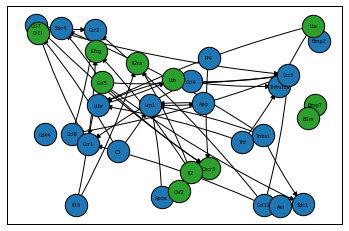

In [10]:
alpha = 0.05
n = 2

ntests = len(allEx)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")
pdf = res.copy()
pdf = pdf[pdf['pval'] < alpha]

# build the edgelist from the LR pairs data 
ldf = lr[(lr['ligand'].isin(pdf['gene'])) & (lr['receptor'].isin(pdf['gene']))]
ldf = ldf[['ligand', 'receptor']].reset_index(drop=True)

# drop genes not in LR pairs
keepList = list(set(ldf['ligand'].to_list() + ldf['receptor'].to_list()))
pdf = pdf[pdf['gene'].isin(keepList)]


# annotate the DEG with the targets 
def getTarget(x, search_as, ldf):
    return_as = 'ligand'
    if search_as == 'ligand':
        return_as = 'receptor'
    
    return ldf[ldf[search_as] == x][return_as].to_list()

pdf['receptors'] = pdf['gene'].apply(lambda x: getTarget(x, 'ligand', ldf))
pdf['ligands'] = pdf['gene'].apply(lambda x: getTarget(x, 'receptor', ldf))
pdf['nlig'] = pdf['ligands'].apply(lambda x : len(x))
pdf['nrec'] = pdf['receptors'].apply(lambda x : len(x))

pdf = pdf[(pdf['nlig'] > n) | (pdf['nrec'] > n)]





G = nx.DiGraph()

nodes = [(k, v) for k, v in pdf.set_index('gene').to_dict('index').items()]
print(len(nodes))
G.add_nodes_from(nodes)




for idx, ligand in pdf.iterrows():
    ligKey = ligand['gene']
    for recKey in ligand['receptors']:
        receptor = pdf[pdf['gene'] == recKey].T
        
        if ligKey in G.nodes() and recKey in G.nodes():
            G.add_weighted_edges_from([(ligKey, recKey, ligand['nrec'])])
        

        

# G.pos = nx.circular_layout(G)
# G.pos = nx.kamada_kawai_layout(G, scale=1)
G.pos = nx.random_layout(G)

# G.pos = graphviz_layout(G, prog='neato')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 11, 11
plt.rcParams['figure.facecolor'] = "w"

labels = {}

for n in G.nodes():
    labels[n] = str(n).lower().capitalize()
    
    
mask = pdf['log2foldchange'] > 0
innateGenes = pdf[mask]['gene'].to_list()
adaptiveGenes = pdf[~mask]['gene'].to_list()
print(f"{len(innateGenes)=} {len(adaptiveGenes)=}" )
    
nx.draw_networkx_nodes(G, 
                       G.pos,
                       nodelist=innateGenes,
                       node_color='C0',
                       node_size=500,
                       linewidths=1,
                       edgecolors='k',
                      )

nx.draw_networkx_nodes(G, 
                       G.pos,
                       nodelist=adaptiveGenes,
                       node_color='C2',
                       node_size=500,
                       linewidths=1,
                       edgecolors='k',
                      )

nx.draw_networkx_labels(G, 
                        G.pos,
                        labels=labels,
                        font_size=5)

nx.draw_networkx_edges(G, 
                       G.pos,
                       connectionstyle="arc3,rad=0.05",
                      )

print()

In [11]:
G.pos

{'IL15': array([0.15389062, 0.0176102 ], dtype=float32),
 'LTB': array([0.4904459, 0.6937047], dtype=float32),
 'CCL8': array([0.13858846, 0.40094933], dtype=float32),
 'BMP7': array([0.9887335, 0.5572484], dtype=float32),
 'THBS1': array([0.8048321, 0.3922252], dtype=float32),
 'CXCR3': array([0.6171561 , 0.21462414], dtype=float32),
 'CSF2': array([0.51141524, 0.09089548], dtype=float32),
 'CCL12': array([0.81003535, 0.01728925], dtype=float32),
 'TNFRSF1A': array([0.863016, 0.656801], dtype=float32),
 'CD44': array([0.04350426, 0.39683813], dtype=float32),
 'CCL4': array([0.5550632 , 0.68215585], dtype=float32),
 'CCL5': array([0.24281834, 0.676693  ], dtype=float32),
 'LTA': array([0.9803108, 0.9833559], dtype=float32),
 'CCR1': array([0.1952721 , 0.34696898], dtype=float32),
 'SDC4': array([0.0995082 , 0.96969503], dtype=float32),
 'CCL7': array([0.01407246, 0.98490846], dtype=float32),
 'IL2': array([0.55370826, 0.19234025], dtype=float32),
 'CCR5': array([0.8938249, 0.7178975], 

In [12]:

# # drop results not in LR pairs
# keepList = list(set(ldf['ligand'].to_list() + ldf['receptor'].to_list()))
# pdf['geneName'] = pdf['gene'].apply(lambda x: str(x).lower().capitalize())
# pdf = pdf[pdf['gene'].isin(keepList)]
# pdf = res.sort_values(by='log2foldchange', ascending=False)


# labels = dict(zip(pdf['gene'].values, pdf['geneName'].values))
# innateGenes = pdf[pdf['log2foldchange'] < 0]['gene'].to_list()


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 11, 11
# plt.rcParams['figure.facecolor'] = "w"
# G = nx.from_pandas_edgelist(ldf,
#                             source='ligand',
#                             target='receptor',
#                             create_using=nx.DiGraph())

# G.pos = nx.circular_layout(G)
# # G.pos = nx.bipartite_layout(G, innateGenes, align='horizontal')
# nx.draw_networkx(G, 
#                  pos=G.pos,
#                  node_size=300,
#                  edgecolors='k',
#                  linewidths=1,
#                  labels=labels,
#                  font_size=3)

# G.nodes()

# # merge in the metadata
# node_attr = pdf.set_index('gene').to_dict('index')
# nx.set_node_attributes(G, node_attr)  

         
    


# innateGenes = pdf[pdf['log2foldchange'] > 0]['gene'].to_list()
# adaptiveGenes = pdf[pdf['log2foldchange'] < 0]['gene'].to_list()


# nodesize = 20
# nx.draw_networkx_nodes(G,
#                        pos=G.pos,
#                        nodelist=innateGenes,
#                        node_size=nodesize,
#                        node_color='C0',
#                        edgecolors='k',
#                        linewidths=1)

# nx.draw_networkx_nodes(G,
#                        pos=G.pos,
#                        nodelist=adaptiveGenes,
#                        node_size=nodesize,
#                        node_color='C2',
#                        edgecolors='k',
#                        linewidths=1)

# # nx.draw_networkx_labels(G, 
#                         pos=G.pos)
     

# nx.draw_networkx_edges(G,
#                        pos=G.pos,
#                        width=1,
#                        edge_color='k')  
    
# for idx, row in pdf.iterrows():
    
    


# top = 20

# pdf = pd.concat([pdf.head(top), pdf.tail(top)])
# pdf

